In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
tf.__version__

'2.8.0'

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
train_params = np.load('LHS_params_1dim5000.npz')                #LHS  

In [4]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h']


In [5]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples:', len(train_params['h'])) 
print(train_params['h'])

number of training samples: 5000
[0.73560312 0.72072014 0.78854171 ... 0.79411082 0.79785557 0.72456091]


In [6]:
cosmo_params = np.zeros((len(train_params['h']), 1))
print(cosmo_params[4999])

cosmo_params[:, 0] = train_params['h']

## Training input params:
h = cosmo_params[:, 0]

[0.]


In [7]:
with open('pk_data_1dim5000_np500v2.pkl', 'rb') as f:
    pk_matrix = pickle.load(f)

pk_matrix = np.asarray(pk_matrix).astype('float32')
pk_matrix.dtype

In [8]:
h.dtype

dtype('float64')

In [9]:
# Training input params and output param:

train_H0 = 100*h                               #5000x1                   
train_pk = pk_matrix                           #5000x500                    # don't need kh, stays the same
print("train_pk shape:", np.shape(train_pk))

train_pk shape: (5000, 500)


In [10]:
input_params = np.vstack([train_H0])                                        # 1x5000

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['H0']

output_data = pd.DataFrame(train_pk)                                       
print(input_data)                                                         #5000x1
#print(output_data)

(5000, 1)
(5000, 500)
             H0
0     73.560312
1     72.072014
2     78.854171
3     66.406881
4     76.405681
...         ...
4995  65.373075
4996  70.894179
4997  79.411082
4998  79.785557
4999  72.456091

[5000 rows x 1 columns]


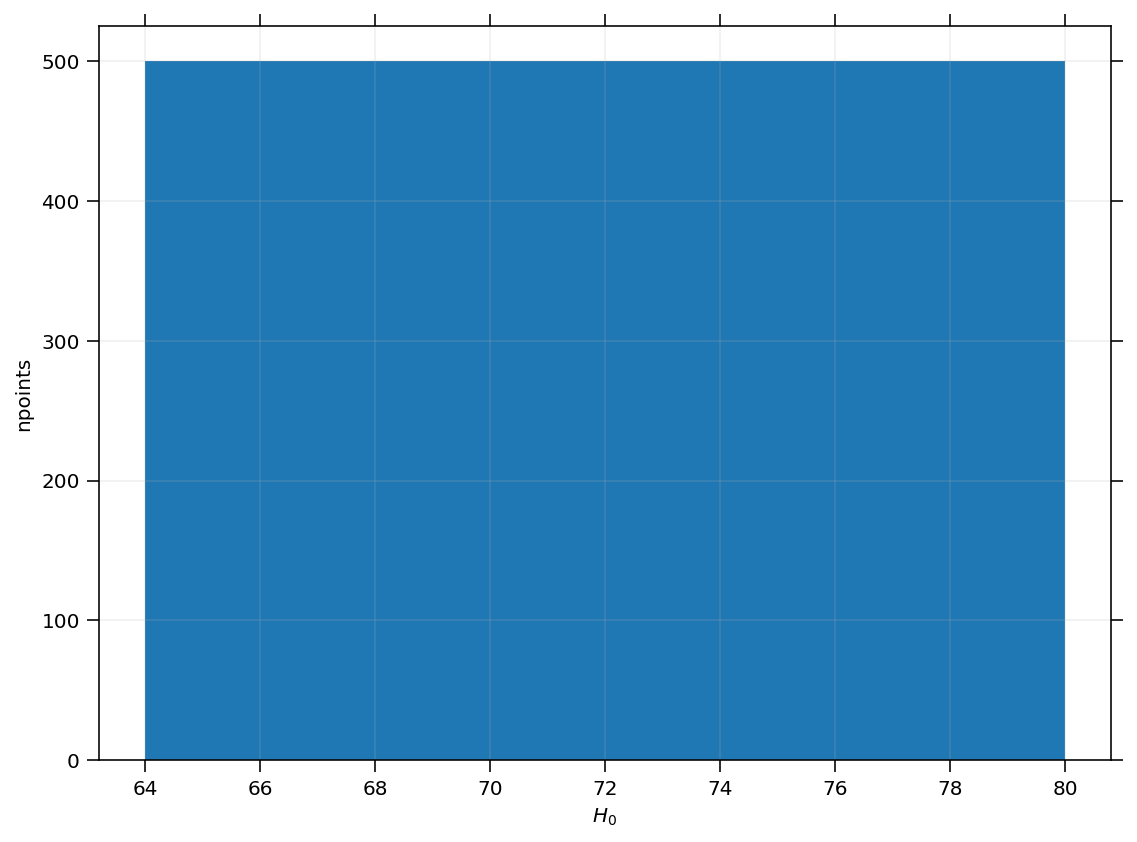

In [11]:
plt.figure(figsize = (8,6))
plt.hist(input_data['H0'])
plt.xlabel(r'$H_{0}$')
plt.ylabel('npoints')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.tight_layout()

In [12]:
# Standardising:

train_input_data = StandardScaler()
test_output_data = StandardScaler()

# Storing the fit object for later reference
scaled_input = train_input_data.fit(input_data.values)              # Compute the mean and std to be used for later scaling

scaled_output = test_output_data.fit(output_data.values)

# Generating the standardized values of input and output:
X = scaled_input.transform(input_data.values)                              # Perform standardisation by centring and scaling    
y = scaled_output.transform(output_data.values)             
print(X)

[[0.33774991]
 [0.01558846]
 [1.48367475]
 ...
 [1.60422549]
 [1.68528547]
 [0.0987269 ]]


-1.731704432041452 3.2288794726326353


(array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500.]),
 array([-1.73170443, -1.38536355, -1.03902266, -0.69268177, -0.34634089,
         0.        ,  0.34634089,  0.69268177,  1.03902266,  1.38536355,
         1.73170443]),
 <BarContainer object of 10 artists>)

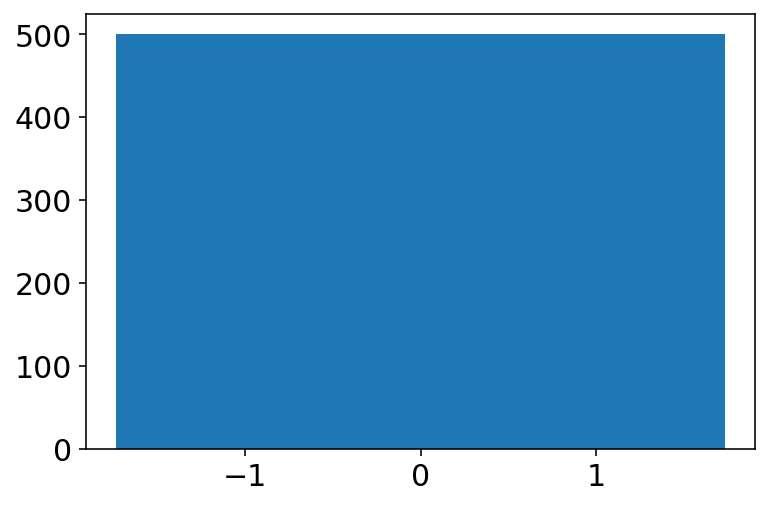

In [13]:
print(X.min(), y.max())
plt.hist(X)

In [14]:
# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_train))    # 4000x1
print(X_train.shape[1])     # 1

(4000, 1)
1


In [15]:
print(X_train)

[[ 1.5501855 ]
 [-0.72434366]
 [-0.804018  ]
 ...
 [ 0.49432731]
 [-0.58855088]
 [-0.87122157]]


In [16]:
print("y_test samples, pts:", np.shape(y_test))
print("y_train samples, pts:", np.shape(y_train))
print("X_train samples, pts:", np.shape(X_train))
print("X_test samples, pts:",np.shape(X_test))
#print("X_train:", X_train)
#print("X_test:", X_test)

y_test samples, pts: (1000, 500)
y_train samples, pts: (4000, 500)
X_train samples, pts: (4000, 1)
X_test samples, pts: (1000, 1)


In [17]:
%%time
#Building the NN:

tf_model = Sequential()
# Defining the input layer of the model
tf_model.add(Dense(units=250, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # 
 
# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model.add(Dense(500, kernel_initializer='normal'))
 
opt = keras.optimizers.Adam(learning_rate=1e-4)
    
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_ = tf_model.fit(X_train, y_train, batch_size = 50, epochs = 250, validation_split=0.2, verbose=1)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#99.44523163935358, l_rate = 1e-4, 250 epochs
tf_model.summary()

Epoch 1/250
64/64 [==============================] - 1s 5ms/step - loss: 0.9745 - accuracy: 0.0000e+00 - val_loss: 0.8776 - val_accuracy: 0.0000e+00
Epoch 2/250
64/64 [==============================] - 0s 3ms/step - loss: 0.5707 - accuracy: 0.0000e+00 - val_loss: 0.1836 - val_accuracy: 0.0000e+00
Epoch 3/250
64/64 [==============================] - 0s 3ms/step - loss: 0.0833 - accuracy: 0.0000e+00 - val_loss: 0.0498 - val_accuracy: 0.0000e+00
Epoch 4/250
64/64 [==============================] - 0s 3ms/step - loss: 0.0463 - accuracy: 0.0194 - val_loss: 0.0430 - val_accuracy: 0.0425
Epoch 5/250
64/64 [==============================] - 0s 3ms/step - loss: 0.0420 - accuracy: 0.0391 - val_loss: 0.0395 - val_accuracy: 0.0425
Epoch 6/250
64/64 [==============================] - 0s 3ms/step - loss: 0.0382 - accuracy: 0.0316 - val_loss: 0.0354 - val_accuracy: 0.0425
Epoch 7/250
64/64 [==============================] - 0s 3ms/step - loss: 0.0336 - accuracy: 0.0378 - val_loss: 0.0302 - val_accura

Epoch 57/250
64/64 [==============================] - 0s 3ms/step - loss: 5.4024e-05 - accuracy: 0.8956 - val_loss: 5.2774e-05 - val_accuracy: 0.8788
Epoch 58/250
64/64 [==============================] - 0s 3ms/step - loss: 5.1473e-05 - accuracy: 0.9044 - val_loss: 5.0632e-05 - val_accuracy: 0.8900
Epoch 59/250
64/64 [==============================] - 0s 3ms/step - loss: 4.9719e-05 - accuracy: 0.9075 - val_loss: 4.8983e-05 - val_accuracy: 0.8963
Epoch 60/250
64/64 [==============================] - 0s 3ms/step - loss: 4.7613e-05 - accuracy: 0.9122 - val_loss: 4.7425e-05 - val_accuracy: 0.9013
Epoch 61/250
64/64 [==============================] - 0s 3ms/step - loss: 4.5311e-05 - accuracy: 0.9100 - val_loss: 4.4006e-05 - val_accuracy: 0.9062
Epoch 62/250
64/64 [==============================] - 0s 3ms/step - loss: 4.3501e-05 - accuracy: 0.9159 - val_loss: 4.3180e-05 - val_accuracy: 0.9025
Epoch 63/250
64/64 [==============================] - 0s 3ms/step - loss: 4.2192e-05 - accuracy: 0.9

64/64 [==============================] - 0s 3ms/step - loss: 1.0854e-05 - accuracy: 0.9625 - val_loss: 1.4444e-05 - val_accuracy: 0.9550
Epoch 112/250
64/64 [==============================] - 0s 3ms/step - loss: 1.0585e-05 - accuracy: 0.9609 - val_loss: 1.0019e-05 - val_accuracy: 0.9613
Epoch 113/250
64/64 [==============================] - 0s 3ms/step - loss: 1.1027e-05 - accuracy: 0.9625 - val_loss: 1.1736e-05 - val_accuracy: 0.9600
Epoch 114/250
64/64 [==============================] - 0s 3ms/step - loss: 1.0175e-05 - accuracy: 0.9628 - val_loss: 1.0550e-05 - val_accuracy: 0.9613
Epoch 115/250
64/64 [==============================] - 0s 3ms/step - loss: 9.7689e-06 - accuracy: 0.9641 - val_loss: 9.3035e-06 - val_accuracy: 0.9663
Epoch 116/250
64/64 [==============================] - 0s 3ms/step - loss: 9.6651e-06 - accuracy: 0.9647 - val_loss: 9.6264e-06 - val_accuracy: 0.9675
Epoch 117/250
64/64 [==============================] - 0s 3ms/step - loss: 9.6235e-06 - accuracy: 0.9669 - v

64/64 [==============================] - 0s 3ms/step - loss: 6.1690e-06 - accuracy: 0.9787 - val_loss: 4.7562e-06 - val_accuracy: 0.9737
Epoch 166/250
64/64 [==============================] - 0s 3ms/step - loss: 5.1079e-06 - accuracy: 0.9803 - val_loss: 4.6325e-06 - val_accuracy: 0.9762
Epoch 167/250
64/64 [==============================] - 0s 3ms/step - loss: 5.8220e-06 - accuracy: 0.9803 - val_loss: 4.8117e-06 - val_accuracy: 0.9775
Epoch 168/250
64/64 [==============================] - 0s 3ms/step - loss: 5.0739e-06 - accuracy: 0.9778 - val_loss: 5.1831e-06 - val_accuracy: 0.9750
Epoch 169/250
64/64 [==============================] - 0s 3ms/step - loss: 7.0034e-06 - accuracy: 0.9791 - val_loss: 1.0912e-05 - val_accuracy: 0.9787
Epoch 170/250
64/64 [==============================] - 0s 3ms/step - loss: 6.4798e-06 - accuracy: 0.9787 - val_loss: 4.7827e-06 - val_accuracy: 0.9688
Epoch 171/250
64/64 [==============================] - 0s 3ms/step - loss: 5.0764e-06 - accuracy: 0.9797 - v

64/64 [==============================] - 0s 3ms/step - loss: 3.6051e-06 - accuracy: 0.9825 - val_loss: 2.7653e-06 - val_accuracy: 0.9787
Epoch 220/250
64/64 [==============================] - 0s 3ms/step - loss: 3.9428e-06 - accuracy: 0.9825 - val_loss: 3.3835e-06 - val_accuracy: 0.9787
Epoch 221/250
64/64 [==============================] - 0s 3ms/step - loss: 7.2235e-06 - accuracy: 0.9850 - val_loss: 3.5635e-06 - val_accuracy: 0.9775
Epoch 222/250
64/64 [==============================] - 0s 3ms/step - loss: 3.6182e-06 - accuracy: 0.9831 - val_loss: 2.9978e-06 - val_accuracy: 0.9787
Epoch 223/250
64/64 [==============================] - 0s 3ms/step - loss: 3.4867e-06 - accuracy: 0.9791 - val_loss: 4.2729e-06 - val_accuracy: 0.9775
Epoch 224/250
64/64 [==============================] - 0s 3ms/step - loss: 3.7700e-06 - accuracy: 0.9825 - val_loss: 2.8513e-06 - val_accuracy: 0.9725
Epoch 225/250
64/64 [==============================] - 0s 3ms/step - loss: 3.3713e-06 - accuracy: 0.9831 - v

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

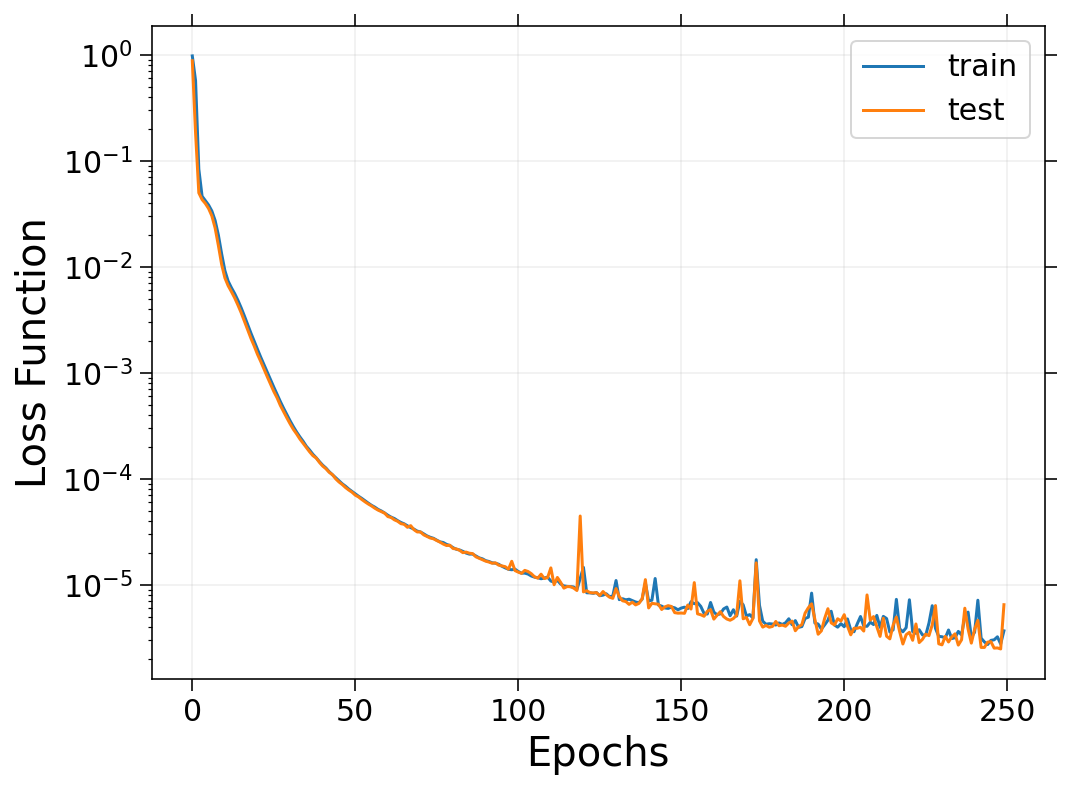

In [19]:
plt.figure(figsize = (8,6))
plt.plot(hist_.history["loss"], label="train")
plt.plot(hist_.history["val_loss"], label="test")
plt.legend(fontsize=15)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('Loss_Func_H0.jpg')
plt.tight_layout

H0: 64.0 - 80.0 67.66


parameter:  ['67.66']
user_list: [67.66]
cosmo_arr [[67.66]]
cosmo_arr[0] [67.66]
input_scaled [[-0.93944965]]
H0: 67.66


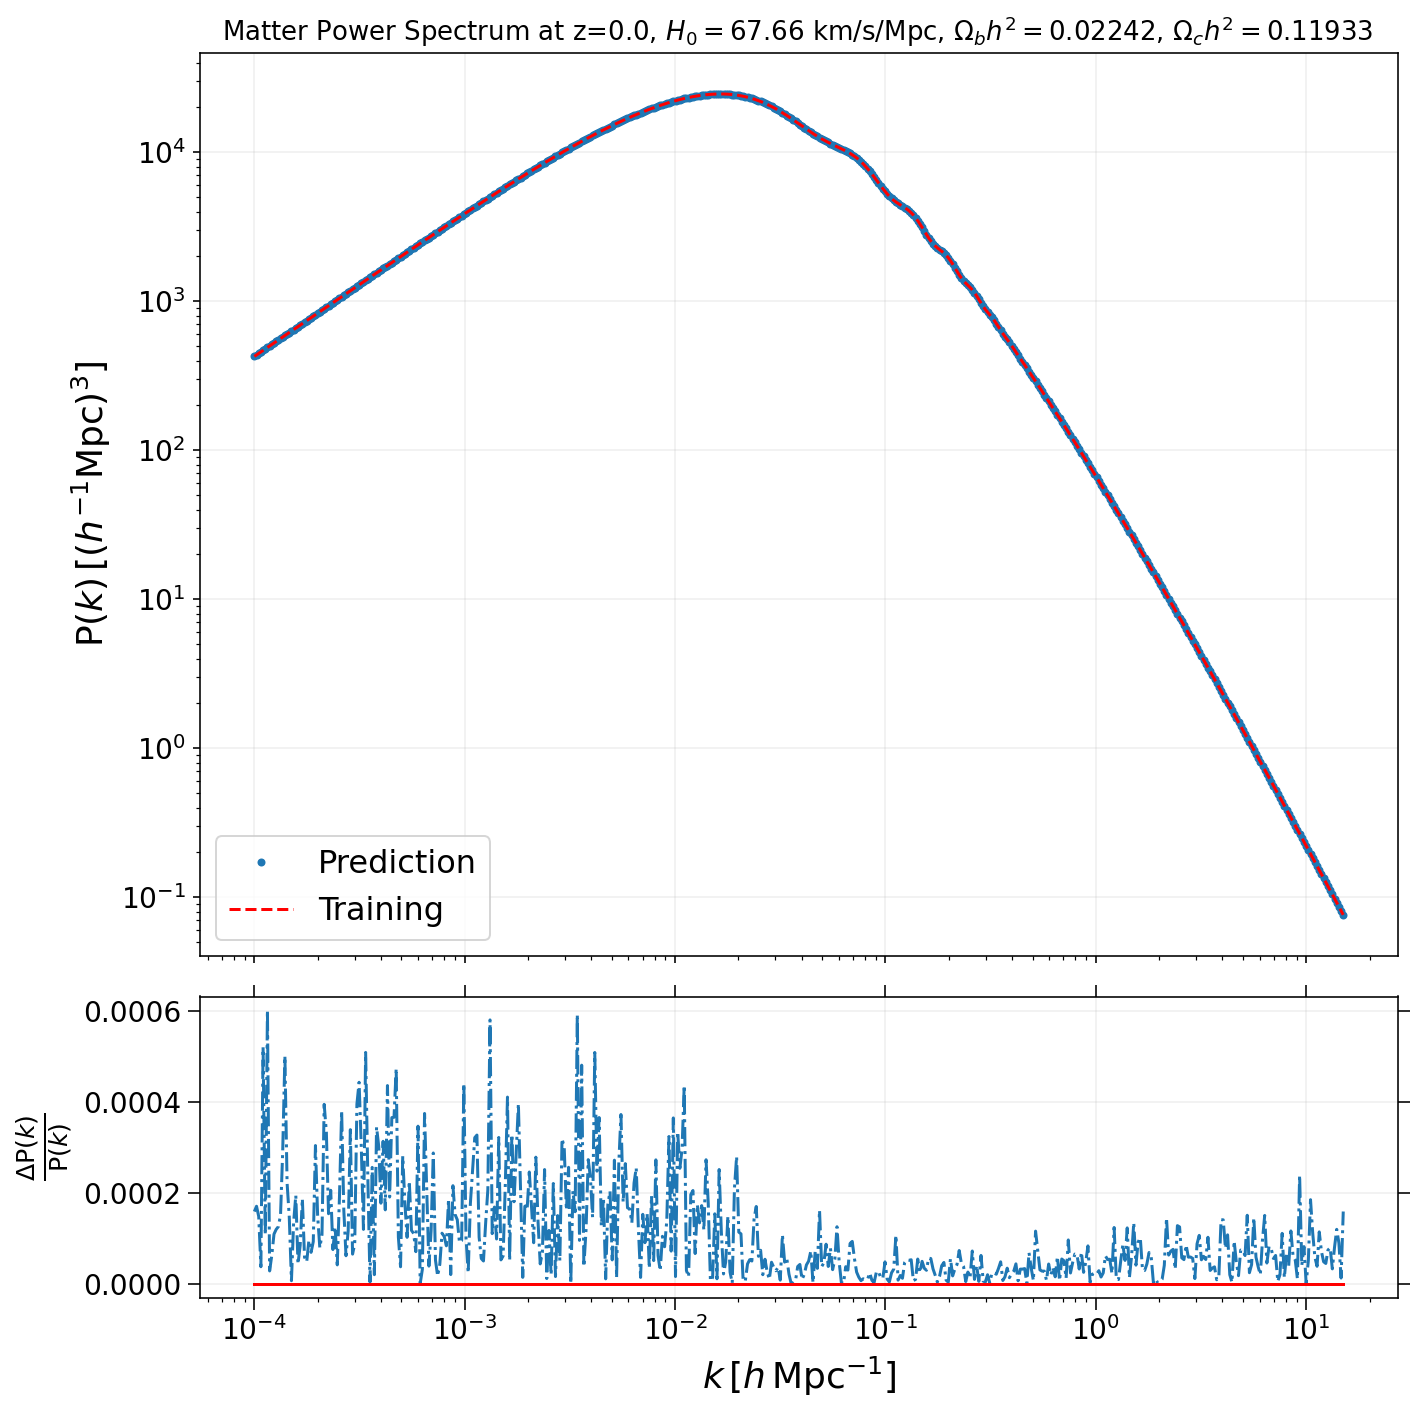

In [31]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('H0: 64.0 - 80.0 ')
    print("\n")
    user_list = input_cosmo_val.split()
    # print list
    print('parameter: ', user_list)

    # convert each item to float type
    for i in range(len(user_list)):
        # convert each item to float type
        user_list[i] = float(user_list[i])
    print("user_list:", user_list)
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
    print('cosmo_arr', cosmo_arr)
    print('cosmo_arr[0]', cosmo_arr[0])
    scaled = train_input_data.fit(input_data.values)
    input_scaled = scaled.transform(cosmo_arr)
    print('input_scaled', input_scaled)
    
    pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
    #Return to log scale for pred:
    #pred_pk = np.exp(pred_rescaled_pk)
    
    
    #Compute P.S via CAMB:
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=0.02242, omch2=0.11933)
    pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
    pars.set_matter_power(redshifts=[0.0], kmax=15.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
    s8_current = np.array(results.get_sigma8())
    s8_fid = np.array([0.8102])
    renorm_s8 = (s8_fid/s8_current)**2
    camb_pk = renorm_s8*camb_pk_cur


    print('H0:' , cosmo_arr[0][0])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (10,10), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(camb_kh, pred_pk[0], "C0.")                                                          # prediction                            
    ax[0].loglog(camb_kh, camb_pk[0], 'r', linestyle='dashed')                                          # CAMB                          
    ax[0].set_title('Matter Power Spectrum at z=0.0, $H_{0} = %0.5s \ \mathregular{km/s/Mpc}$, ' %cosmo_arr[0][0] + '$\Omega_{b}h^{2} = 0.02242$, ' + '$\Omega_{c}h^{2} = 0.11933$ ', fontsize = 13)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction', 'Training'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0]), 'C0', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]), 'r')
    ax[1].set_yscale('linear')
    #ax[1].set_ylim(0, 0.05)
    fig.tight_layout()
    plt.savefig('NN_MPS_H0.jpg')
    plt.show()
    

Generate = calc_cosmo()



parameter:  64.0
user_list: 64.0
cosmo_arr [[64.]]
cosmo_arr[0] [64.]
input_scaled [[-1.73170443]]
H0: 64.0


parameter:  66.28571428571429
user_list: 66.28571428571429
cosmo_arr [[66.28571429]]
cosmo_arr[0] [66.28571429]
input_scaled [[-1.23693174]]
H0: 66.28571428571429


parameter:  68.57142857142857
user_list: 68.57142857142857
cosmo_arr [[68.57142857]]
cosmo_arr[0] [68.57142857]
input_scaled [[-0.74215904]]
H0: 68.57142857142857


parameter:  70.85714285714286
user_list: 70.85714285714286
cosmo_arr [[70.85714286]]
cosmo_arr[0] [70.85714286]
input_scaled [[-0.24738635]]
H0: 70.85714285714286


parameter:  73.14285714285714
user_list: 73.14285714285714
cosmo_arr [[73.14285714]]
cosmo_arr[0] [73.14285714]
input_scaled [[0.24738635]]
H0: 73.14285714285714


parameter:  75.42857142857143
user_list: 75.42857142857143
cosmo_arr [[75.42857143]]
cosmo_arr[0] [75.42857143]
input_scaled [[0.74215904]]


KeyboardInterrupt: 

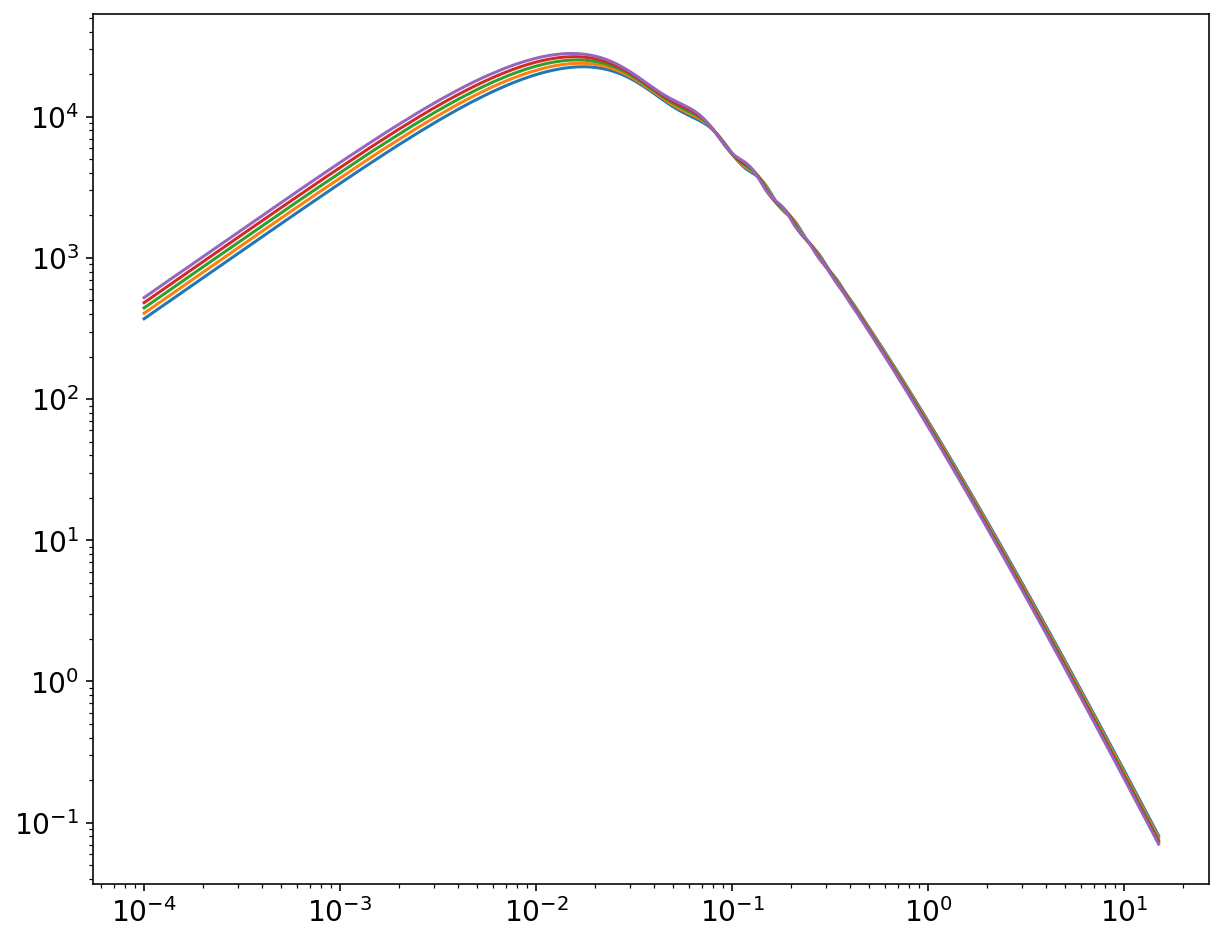

In [32]:
#Define func:

def calc_cosmo():
    plt.figure(figsize = (10,8))
    H0_input = np.linspace(64.0, 80.0, 8)
    for w in H0_input:
        
        print("\n")
        user_list = float(w)
        # print list
        print('parameter: ', user_list)

        # convert each item to float type
        print("user_list:", user_list)
        
    
        cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
        print('cosmo_arr', cosmo_arr)
        print('cosmo_arr[0]', cosmo_arr[0])
        scaled = train_input_data.fit(input_data.values)
        input_scaled = scaled.transform(cosmo_arr)
        print('input_scaled', input_scaled)

        pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
        #Return to log scale for pred:
        #pred_pk = np.exp(pred_rescaled_pk)
    
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=0.02242, omch2=0.11933)
        pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
        pars.set_matter_power(redshifts=[0.0], kmax=15.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
        s8_current = np.array(results.get_sigma8())
        s8_fid = np.array([0.8102])
        renorm_s8 = (s8_fid/s8_current)**2
        camb_pk = renorm_s8*camb_pk_cur


        print('H0:' , cosmo_arr[0][0])
        
                                             
        plt.loglog(camb_kh, pred_pk[0])                                                          # prediction                            
        #plt.loglog(camb_kh, camb_pk[0], 'r' , linestyle='dashed')                               # CAMB                          
    plt.title('Emulation of Matter Power Spectrum at z=0.0, ' + '$\Omega_{b}h^{2} = 0.02242$, ' + '$\Omega_{c}h^{2} = 0.11933$, ', fontsize = 14)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    plt.legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in  H0_input], loc='lower left', fontsize=16);
    plt.grid(alpha=0.2)
    plt.grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)

    plt.tight_layout()
    #plt.savefig('NN_MPS_H0_range.jpg')
    plt.show()
    

Generate = calc_cosmo()



parameter:  64.0
user_list: 64.0
cosmo_arr [[64.]]
cosmo_arr[0] [64.]
input_scaled [[-1.73170443]]
H0: 64.0


parameter:  66.28571428571429
user_list: 66.28571428571429
cosmo_arr [[66.28571429]]
cosmo_arr[0] [66.28571429]
input_scaled [[-1.23693174]]
H0: 66.28571428571429


parameter:  68.57142857142857
user_list: 68.57142857142857
cosmo_arr [[68.57142857]]
cosmo_arr[0] [68.57142857]
input_scaled [[-0.74215904]]
H0: 68.57142857142857


parameter:  70.85714285714286
user_list: 70.85714285714286
cosmo_arr [[70.85714286]]
cosmo_arr[0] [70.85714286]
input_scaled [[-0.24738635]]
H0: 70.85714285714286


parameter:  73.14285714285714
user_list: 73.14285714285714
cosmo_arr [[73.14285714]]
cosmo_arr[0] [73.14285714]
input_scaled [[0.24738635]]
H0: 73.14285714285714


parameter:  75.42857142857143
user_list: 75.42857142857143
cosmo_arr [[75.42857143]]
cosmo_arr[0] [75.42857143]
input_scaled [[0.74215904]]
H0: 75.42857142857143


parameter:  77.71428571428571
user_list: 77.71428571428571
cosmo_

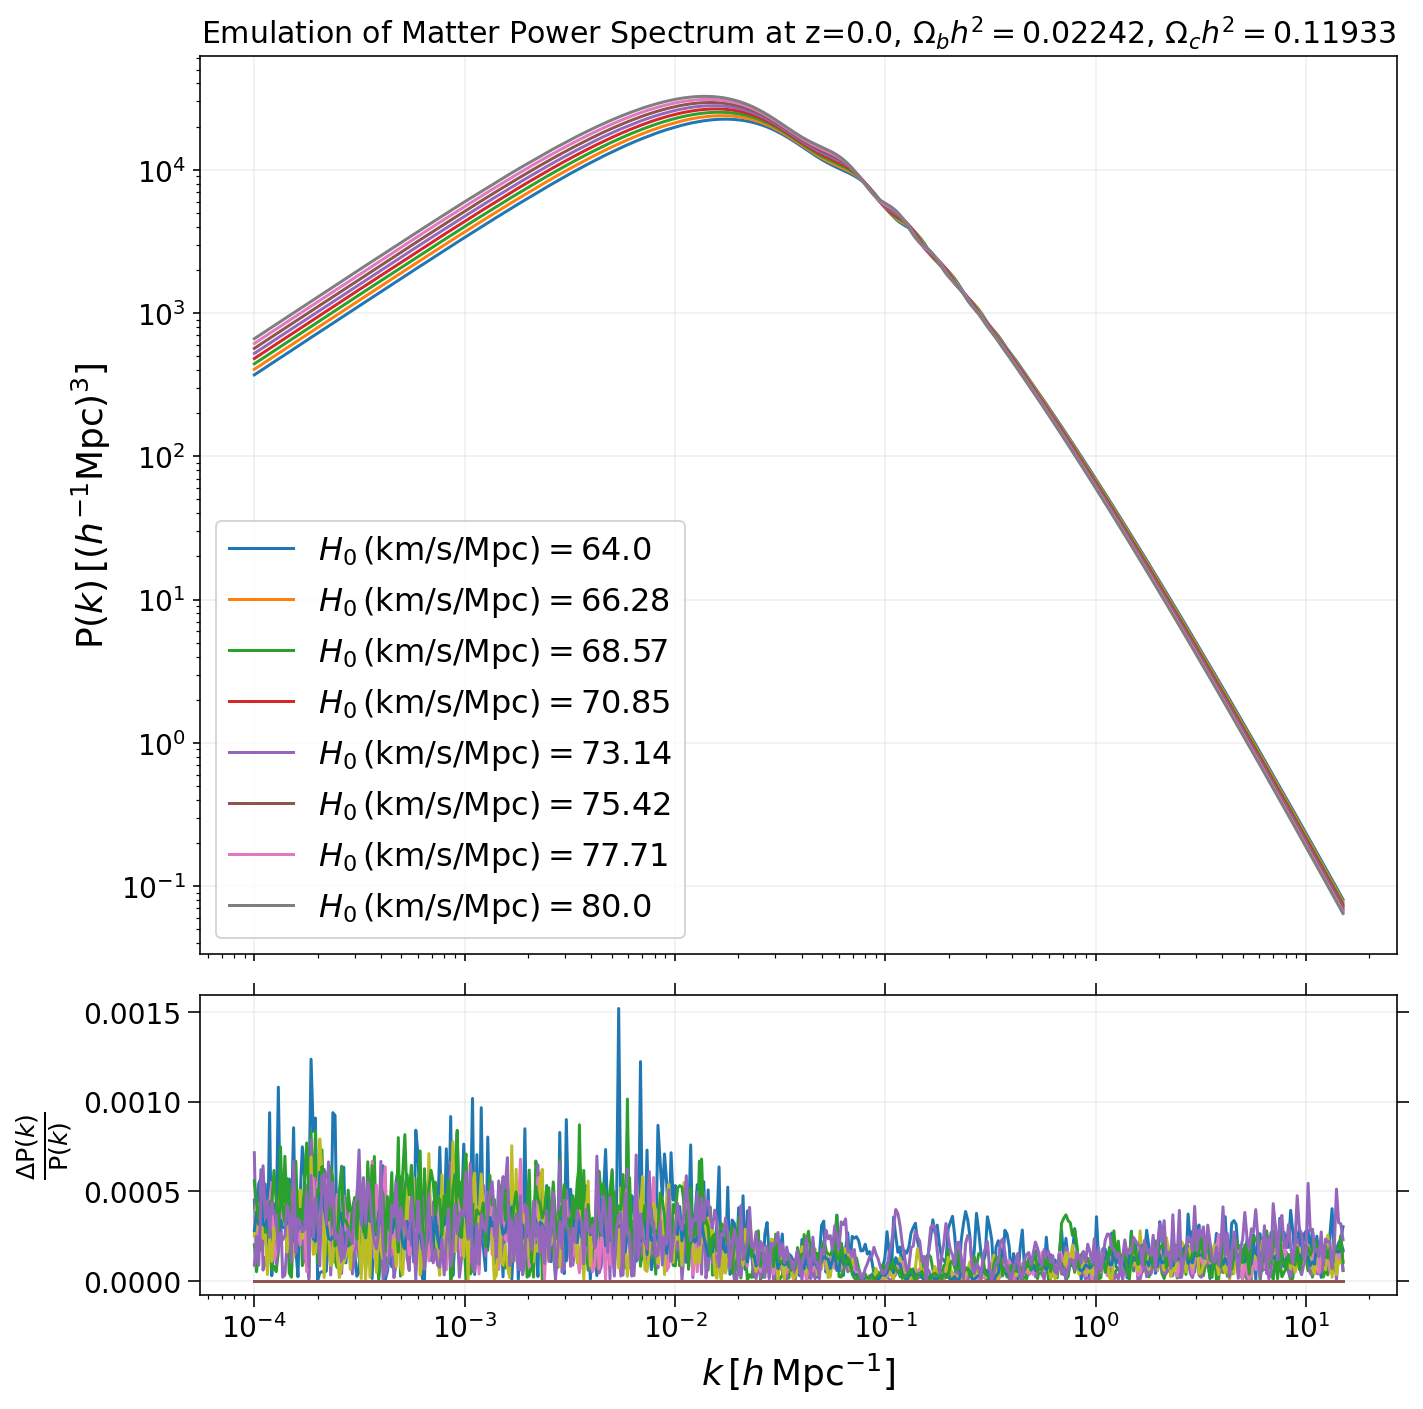

In [35]:
# Define func:

def calc_cosmo():
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (10,10), gridspec_kw={'height_ratios': [3, 1]})
    H0_input = np.linspace(64.0, 80.0, 8)
    for w in H0_input:
        
        print("\n")
        user_list = float(w)
        # print list
        print('parameter: ', user_list)

        # convert each item to float type
        print("user_list:", user_list)
        
    
        cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
        print('cosmo_arr', cosmo_arr)
        print('cosmo_arr[0]', cosmo_arr[0])
        scaled = train_input_data.fit(input_data.values)
        input_scaled = scaled.transform(cosmo_arr)
        print('input_scaled', input_scaled)

        pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
        #Return to log scale for pred:
        #pred_pk = np.exp(pred_rescaled_pk)
    
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=0.02242, omch2=0.11933)
        pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
        pars.set_matter_power(redshifts=[0.0], kmax=15.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
        s8_current = np.array(results.get_sigma8())
        s8_fid = np.array([0.8102])
        renorm_s8 = (s8_fid/s8_current)**2
        camb_pk = renorm_s8*camb_pk_cur


        print('H0:' , cosmo_arr[0][0])
        
                                             
        ax[0].loglog(camb_kh, pred_pk[0])                                                    # prediction                            
        #ax[0].loglog(camb_kh, camb_pk[0])    # linestyle='dashed'                            # CAMB
        
        #residual plot 
        ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
        ax[1].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0])) 
        ax[1].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]))
        ax[1].set_yscale('linear')
        #ax[1].set_ylim(0, 0.05)
        
    ax[0].set_title('Emulation of Matter Power Spectrum at z=0.0, ' + '$\Omega_{b}h^{2} = 0.02242$, ' + '$\Omega_{c}h^{2} = 0.11933$', fontsize = 15)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(["$H_{0}\,\mathregular{(km/s/Mpc)} = %0.5s$"%w for w in  H0_input], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)


        
    fig.tight_layout()
    plt.savefig('NN_MPS_H0_range.jpg')
    plt.show()
    

Generate = calc_cosmo()